## Text splitters

In [33]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]

You can't understand the world without understanding the concept of superlinear returns. And if you're ambitious you definitely should, because this will be the wave you surf on.

It may seem as if there are a lot of different situations with superlinear returns, but as far as I can tell they reduce to two fundamental causes: exponential growth and thresholds.

The most obvious case of superlinear returns is when you're working on something that grows exponentially. For example, growing bacterial cultures. When they grow at all, they grow exponentially. But they're tricky to grow. Which means the difference in outcome between someone who's adept at it and someone who's not is very great.

Startups can also grow exponentially, and we see the same pattern there. Some manage to achieve high growth rates. Most don't. And as a result you get qualitatively different outcomes: the companies with high growth rates tend to become immensely valuable, while the ones with lower growth rates may not even survive.

Y Combinator encourages founders to focus on growth rate rather than absolute numbers. It prevents them from being discouraged early on, when the absolute numbers are still low. It also helps them decide what to focus on: you can use growth rate as a compass to tell you how to evolve the company. But the main advantage is that by focusing on growth rate you tend to get something that grows exponentially.

YC doesn't explicitly tell founders that with growth rate "you get out what you put in," but it's not far from the truth. And if growth rate were proportional to performance, then the reward for performance p over time t would be proportional to pt.

Even after decades of thinking about this, I find that sentence startling.

"""


### CharacterTextSplitter

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
character_splitter = CharacterTextSplitter(
    separator=str(),
    chunk_size=500,
    chunk_overlap=5,
    length_function=len,
    is_separator_regex=False,
)

splits = character_splitter.create_documents([text])
splits

In [ ]:
import textwrap
for document in splits:
    print(textwrap.fill(document.page_content,100))
    print("-"*75)

### RecursiveCharacterTextSplitter

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
recursive_character_splitter  = RecursiveCharacterTextSplitter(
                                                chunk_size=500,
                                                chunk_overlap=75,
                                                length_function=len,
                                                is_separator_regex=False,
                                                )

splits = recursive_character_splitter.create_documents([text])
splits

In [ ]:
import textwrap
for document in splits:
    print(textwrap.fill(document.page_content,100))
    print("-"*75)

### Domain Specific splitter

In [61]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language

In [ ]:
l = [e for e in Language]
print(l)

In [ ]:
RecursiveCharacterTextSplitter.get_separators_for_language(Language.PYTHON)



#### Python Splitter

In [ ]:
PYTHON_CODE = """
def hello_world():
    print("Hello, World!")

# Call the function
hello_world()
"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=50, chunk_overlap=0
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

In [ ]:
for python_doc in python_docs:
    print(python_doc.page_content)
    print("-"*50)

#### JavaScript Splitter

In [ ]:
JS_CODE = """
function helloWorld() {
  console.log("Hello, World!");
}

// Call the function
helloWorld();
"""

js_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.JS, chunk_size=60, chunk_overlap=0
)
js_docs = js_splitter.create_documents([JS_CODE])
js_docs

In [ ]:
for js_doc in js_docs:
    print(js_doc.page_content)
    print("-"*50)

#### Markdown splitter

In [ ]:
markdown_text = """
# 🦜️🔗 LangChain

⚡ Building applications with LLMs through composability ⚡

## Quick Install

# Hopefully this code block isn't split
pip install langchain

As an open-source project in a rapidly developing field, we are extremely open to contributions.
"""
md_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN, chunk_size=60, chunk_overlap=0
)
md_docs = md_splitter.create_documents([markdown_text])
md_docs

In [ ]:
for md_doc in md_docs:
    print(md_doc.page_content)
    print("-"*50)

#### HTML Splitter

In [ ]:
html_text = """
<!DOCTYPE html>
<html>
    <head>
        <title>🦜️🔗 LangChain</title>
        <style>
            body {
                font-family: Arial, sans-serif;
            }
            h1 {
                color: darkblue;
            }
        </style>
    </head>
    <body>
        <div>
            <h1>🦜️🔗 LangChain</h1>
            <p>⚡ Building applications with LLMs through composability ⚡</p>
        </div>
        <div>
            As an open-source project in a rapidly developing field, we are extremely open to contributions.
        </div>
    </body>
</html>
"""
html_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.HTML, chunk_size=60, chunk_overlap=0
)
html_docs = html_splitter.create_documents([html_text])
html_docs

In [ ]:
for html_doc in html_docs:
    print(html_doc.page_content)
    print("-"*50)

You can find more code splitters in [How to split code by 🦜️🔗
](https://python.langchain.com/v0.2/docs/how_to/code_splitter/#html)

#### Semantic Chunking



Embeddings represent the semantic meaning of a string. They don't do much on their own, but when compared to embeddings of other texts you can start to infer the relationship between chunks. I want to lean into this property and explore using embeddings to find clusters of semantically similar texts.

The hypothesis is that semantically similar chunks should be held together.

This approach is by [Greg Kamradt](https://www.youtube.com/@DataIndependent) , All credit to him.


**Find break points between sequential sentences** -  He tried a walk method. He started at the first sentence, got the embedding, then compared it to sentence #2, then compared #2 and #3 and so on. He was looking for "break points" where embedding distance was large. If it was above a threshold, then he considered it the start of a new semantic section. He originally tried taking embeddings of every sentence, but this turned out to be too noisy. So he ended up taking groups of 3 sentences (a window), then got an embedding, then dropped the first sentence, and added the next one. This worked out a bit better.



First, let's load up our essay that we'll run through. We're just doing a single essay here to keep the tokens down.

We'll be using Paul Graham's [MIT essay](https://paulgraham.com/mit.html)

In [ ]:
import textwrap

with open(r"E:\Artificial_Intelligence\LLMs\Learn LLMs\mit.txt") as file:
    essay = file.read()

print(textwrap.fill(essay,100))

At a high level, this splits into sentences, then groups into groups of 3 sentences, and then merges one that are similar in the embedding space.

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_ollama import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)


In [ ]:
text_splitter = SemanticChunker(OllamaEmbeddings(model='mxbai-embed-large'))
docs = text_splitter.create_documents([essay])
print(docs[0].page_content)


In [ ]:
for doc in docs:
    print(doc.page_content)
    print("-"*100)

This chunker works by determining when to "break" apart sentences. This is done by looking for differences in embeddings between any two sentences. When that difference is past some threshold, then they are split.

There are a few ways to determine what that threshold is.

##### Percentile

The default way to split is based on percentile. In this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split.



In [ ]:
text_splitter = SemanticChunker(
    OllamaEmbeddings(model = 'mxbai-embed-large'), breakpoint_threshold_type="percentile"
)

docs = text_splitter.create_documents([essay])
print(docs[0].page_content)
print(len(docs))

##### Standard Deviation


In this method, any difference greater than X standard deviations is split.



In [ ]:
text_splitter = SemanticChunker(
    OllamaEmbeddings(model = 'mxbai-embed-large'), breakpoint_threshold_type="standard_deviation"
)

docs = text_splitter.create_documents([essay])
print(docs[0].page_content)
print(len(docs))

You can read [🦜️🔗's official documentaion of Semantic Chunking](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/semantic-chunker/) for more details


## Multi-representation Indexing

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://medium.com/@pankaj_pandey/introduction-to-retrieval-augmented-generation-rag-9209bf8a076d")
docs = loader.load()

loader = WebBaseLoader("https://medium.com/humansdotai/an-introduction-to-ai-agents-e8c4afd2ee8f")
docs.extend(loader.load())

In [ ]:
from langchain.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.retrievers.multi_vector import MultiVectorRetriever

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000)
docs = text_splitter.split_documents(docs)

### Smaller chunks

split a document into smaller chunks, and embed those (this is ParentDocumentRetriever).

Often times it can be useful to retrieve larger chunks of information, but embed smaller chunks. This allows for embeddings to capture the semantic meaning as closely as possible, but for as much context as possible to be passed downstream. Note that this is what the `ParentDocumentRetriever` does. Here we show what is going on under the hood.



In [ ]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=OllamaEmbeddings(model='mxbai-embed-large')
)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
import uuid

doc_ids = [str(uuid.uuid4()) for _ in docs]



In [ ]:
# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

In [ ]:
sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

In [ ]:
retriever.vectorstore.add_documents(sub_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
# Vectorstore alone retrieves the small chunks
retriever.vectorstore.similarity_search("justice breyer")[0]

In [ ]:
# Retriever returns larger chunks
len(retriever.invoke("justice breyer")[0].page_content)

The default search type the retriever performs on the vector database is a similarity search. LangChain Vector Stores also support searching via **Max Marginal Relevance** so if you want this instead you can just set the `search_type property` as follows:



In [ ]:
from langchain.retrievers.multi_vector import SearchType

retriever.search_type = SearchType.mmr

len(retriever.invoke("justice breyer")[0].page_content)

### Summary

create a summary for each document, embed that along with (or instead of) the document.

Oftentimes a summary may be able to distill more accurately what a chunk is about, leading to better retrieval. Here we show how to create summaries, and then embed those.



In [ ]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

In [ ]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOllama(model='llama3.1',max_retries=0)
    | StrOutputParser()
)

In [ ]:
summaries = chain.batch(docs, {"max_concurrency": 5})

Here, `chain.batch()` used to processes multiple inputs (documents) through the chain. and `{"max_concurrency": 5}`: This parameter limits the concurrent processing to 5. meaning the documents will be processed 5 in parallel.


In [ ]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OllamaEmbeddings(model='mxbai-embed-large'))
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

In [ ]:
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

In [ ]:
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
# # We can also add the original chunks to the vectorstore if we so want
# for i, doc in enumerate(docs):
#     doc.metadata[id_key] = doc_ids[i]
# retriever.vectorstore.add_documents(docs)

In [ ]:
sub_docs = vectorstore.similarity_search("justice breyer")

In [ ]:
sub_docs[0]

In [ ]:
retrieved_docs = retriever.invoke("justice breyer")

In [ ]:
len(retrieved_docs[0].page_content)

### Hypothetical Queries


create hypothetical questions that each document would be appropriate to answer, embed those along with (or instead of) the document.

An LLM can also be used to generate a list of hypothetical questions that could be asked of a particular document. These questions can then be embedded



In [136]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Define your desired data structure.
class HypotheticalQuestions(BaseModel):
    questions: list[str] = Field(description="list of hypothetical questions")

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=HypotheticalQuestions)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Function to format the output as required
def format_output(result):
    return [
        {
            "name": "hypothetical_questions",
            "description": "Generate hypothetical questions",
            "parameters": {
                "type": "object",
                "properties": {
                    "questions": {
                        "type": "array",
                        "items": {"type": "string"},
                    },
                },
                "required": ["questions"],
            },
        }
    ]
llm = ChatOllama(model='llama3.1')
chain = prompt | llm | parser



In [ ]:

# Invoke the chain and format the output
result = chain.invoke({"query": s})
formatted_output = format_output(result)

print(formatted_output)

In [141]:
result

{'questions': ['What would happen if AI surpassed human intelligence and became the primary decision-maker?',
  'Could a society where virtual reality has become indistinguishable from reality lead to new forms of social inequality?',
  'Would a global shift towards a resource-based economy require a redefinition of traditional concepts like ownership and wealth?']}

In [ ]:
docs_content = [doc.page_content for doc in docs]
hypothetical_questions = chain.batch(docs_content, {"max_concurrency": 5})

In [ ]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="hypo-questions", embedding_function=OllamaEmbeddings(model='mxbai-embed-large')
)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

In [ ]:
question_docs = []
for i, question_list in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=s, metadata={id_key: doc_ids[i]}) for s in question_list]
    )

In [ ]:
retriever.vectorstore.add_documents(question_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
sub_docs = vectorstore.similarity_search("justice breyer")

In [ ]:
sub_docs

In [ ]:
retrieved_docs = retriever.invoke("justice breyer")

In [ ]:
len(retrieved_docs[0].page_content)

### ColBERT

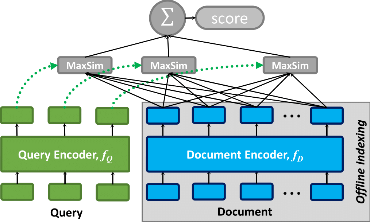

ColBERT generates a contextually influenced vector for each token in the passages.

ColBERT similarly generates vectors for each token in the query.

As Figure 1 illustrates, ColBERT relies on fine-grained contextual late interaction: it encodes each passage into a matrix of token-level embeddings (shown above in blue). Then at search time, it embeds every query into another matrix (shown in green) and efficiently finds passages that contextually match the query using scalable vector-similarity (MaxSim) operators.

These rich interactions allow ColBERT to surpass the quality of single-vector representation models, while scaling efficiently to large corpora.

Instead of using a single vector to represent an entire query or document, ColBERT maintains separate vectors for each token. This allows for more nuanced matching.

The core of ColBERT's matching is the maximum similarity (MaxSim) operation. For each query token, it finds the most similar token in the document.


#### Setup

In [ ]:
%pip install -U ragatouille


#### Create simple RAG from `ragatouille`

Note that:
`ragatouille` is not working on Window , you need to run it on colab if you are using window, or you can use WSL

In [ ]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

#### Get document method

In [ ]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Document_retrieval")

#### ragatouille indexer

In [ ]:
RAG.index(
    collection=[full_document],
    index_name="Doc-1",
    max_document_length=180,
    split_documents=True,
)

In [ ]:
results = RAG.search(query="What is an example for form based indexing?", k=3)
results

#### ragatouille as langchain retriever 

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What is an example for form based indexing?")

## References

- [Split by character](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/character_text_splitter/)
- [Recursively split by character](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/)
- [Split code](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/code_splitter/)
- [Semantic Chunking](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/semantic-chunker/)
- [MultiVector Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/multi_vector/)
- [How ColBERT Helps Developers Overcome the Limits of RAG](https://hackernoon.com/how-colbert-helps-developers-overcome-the-limits-of-rag)
- [RAGatouille](https://python.langchain.com/docs/integrations/retrievers/ragatouille/)
- [Exploring ColBERT with RAGatouille](https://til.simonwillison.net/llms/colbert-ragatouille)